# Deck 281 FOSDIC Parse

headerrows all start with 00000110 and provide data regarding tape reels

-

*80 Columns*

```
M001044205112001140790750830738113 916120103000-----203230188                9R3
^^^^^^YYMMDDHH^^^^                 ^^^^^                         ^^          ^^^
||||||        |||T-ind             |||dry                       water         |
||||||        |||                  |||bulb                       temp        Ship
|||stn #      press (0-999)        |||(F)                         (F)        number
source #      where 10/9 99.9      

```

See Reference manual for more help on temperature conversions

Locations not directly keyed or coded??

For non-999 the id is the lat/lon like deck 110

Octant:

    1: ID
    2: Octant
    3-4: Lat
    5-6: Lon
    
    Where Octant

```s

df2$lat<-ifelse(df2$oct>4,df2$lat*(-1),df2$lat)

df2$lon<-ifelse(df2$oct %in% c(0,5),360-df2$lon,df2$lon)

df2$lon<-ifelse(df2$oct %in% c(1,6),260-df2$lon,df2$lon)

df2$lon<-ifelse(df2$oct %in% c(1,6) & df2$lon < 180, df2$lon+100,df2$lon)

df2$lon<-ifelse(df2$oct %in% c(2,7),101+df2$lon,df2$lon)

df2$lon<-ifelse(df2$oct %in% c(3,8),df2$lon,df2$lon)
```


In [1]:
import pandas as pd
import numpy as np

import datetime
import matplotlib.pyplot as plt


In [2]:
with open('fosdic_cd281','r') as f:
    file = f.readlines()

In [3]:
counter = 0
data = {}
for count, row in enumerate(file):
    if (row[:8] == '00000281'):
        print(f'Headerlines: {count}')
    else:
        try:
            pressure = int(row[15:18]) / 10.
        except:
            pressure = np.nan
        if (pressure < 100):
            pressure = pressure + 1000.
            
        if row[18] == '0':
            tscl = 0
            tmult=1
        elif row[18] == '1':
            tscl = 100
            tmult=1
        elif row[18].lower() == 'x':
            tscl=0
            tmult=-1
        else: ###missing information
            tscl=999
            tmult=1
        try:
            drybulbF = tmult*int(row[19:21])+tscl
        except:
            drybulbF = np.nan
        try:
            datestr = '19'+row[6:8]+'-'+row[8:10]+'-'+row[10:12]+' '+row[12:14]+':00:00'
        except:
            datestr= np.nan

        idbit = np.nan
        latitude = np.nan
        longitude = np.nan 
        if (str(row[0:3]) != '999'): #non-land
            try:
                idbit = row[0:1]
                octant = int(row[1:2])
                lat_str = float(row[2:4])
                lon_str = float(row[4:6])
            except:
                octant = np.nan
                pass
            if octant > 4:
                latitude = -1 * lat_str
            else:
                latitude = 1 * lat_str
                
            if (octant == 0) or (octant == 5):
                lon_str = 360 - lon_str
            else:
                lon_str = lon_str
            if (octant == 1) or (octant == 6):
                lon_str = 260 - lon_str
            else:
                lon_str = lon_str                
            if ((octant == 1) or (octant == 6)) & (lon_str<180):
                lon_str = 100 + lon_str
            else:
                lon_str = lon_str    
            if (octant == 2) or (octant == 7):
                lon_str = 101 + lon_str
            else:
                lon_str = lon_str                  
            if (octant == 3) or (octant == 8):
                lon_str = lon_str                   
            if (octant == 9):
                latitude = np.nan
                longitude = np.nan            
            
            longitude = lon_str
            
        else:
            octant = np.nan
            latitude = np.nan
            longitude = np.nan            

        data.update({counter:{
                    'sourceno':str(row[0:3]),
                    'id':idbit,
                    'octant':octant,
                    'stationno':str(row[3:6]),
                    'latitude':latitude,
                    'longitude':longitude,
                    'year':row[6:8].strip(),
                    'month':row[8:10].strip(),
                    'day':row[10:12].strip(),
                    'hour':row[12:14].strip(),
                    'pressure':pressure,
                    'drybulbF':drybulbF,
                    'rh':row[24:27],
                    'watertempF':row[30:32],
                    'datetime':datestr
                    }})
        counter +=1


Headerlines: 0
Headerlines: 12545
Headerlines: 24536
Headerlines: 36524
Headerlines: 49057
Headerlines: 61535
Headerlines: 73141
Headerlines: 85048
Headerlines: 97027
Headerlines: 109651
Headerlines: 122200
Headerlines: 134700
Headerlines: 146467
Headerlines: 158520
Headerlines: 170536
Headerlines: 182743
Headerlines: 194869
Headerlines: 197588
Headerlines: 209461
Headerlines: 221793
Headerlines: 234155
Headerlines: 246506
Headerlines: 258855
Headerlines: 269829
Headerlines: 281526
Headerlines: 293434
Headerlines: 305693
Headerlines: 318038
Headerlines: 329626
Headerlines: 341159
Headerlines: 352743
Headerlines: 364849
Headerlines: 377043
Headerlines: 388855
Headerlines: 400708
Headerlines: 412589
Headerlines: 425178
Headerlines: 437474
Headerlines: 449347
Headerlines: 461336
Headerlines: 473650
Headerlines: 486216
Headerlines: 498710
Headerlines: 510766
Headerlines: 514180
Headerlines: 525891
Headerlines: 537725
Headerlines: 549901
Headerlines: 562226
Headerlines: 574754
Headerlines: 

In [4]:
df = pd.DataFrame.from_dict(data, orient='index')

In [5]:
#remove empty dates/times
df = df.drop(np.where(df['datetime'] == '19  -  -     :00:00')[0])

In [6]:
df['datetime'] = pd.to_datetime(df['datetime'],errors='coerce').dt.tz_localize('UTC')

In [7]:
for x in df.columns:
    if not x in ['pressure','stationno','sourceno','octant','year','month','day','hour','datetime']:
        df[x] = pd.to_numeric(df[x], errors='coerce')

In [8]:
df

,sourceno,id,octant,stationno,latitude,longitude,year,month,day,hour,pressure,drybulbF,rh,watertempF,datetime
0,-00,NaN,0.0,908,9.0,352.0,35,04,06,12,1012.2,83.0,66.0,81.0,1935-04-06 12:00:00+00:00
1,-00,NaN,0.0,103,1.0,357.0,42,05,11,16,1010.2,79.0,91.0,83.0,1942-05-11 16:00:00+00:00
2,M00,NaN,0.0,104,1.0,356.0,42,05,11,20,1011.4,79.0,83.0,81.0,1942-05-11 20:00:00+00:00
3,M00,NaN,0.0,106,1.0,354.0,42,05,12,04,1010.8,79.0,79.0,82.0,1942-05-12 04:00:00+00:00
4,M00,NaN,0.0,108,1.0,352.0,42,05,12,12,1013.2,81.0,79.0,84.0,1942-05-12 12:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134475,-13,NaN,1.0,040,30.0,220.0,45,03,09,12,1026.4,63.0,84.0,67.0,1945-03-09 12:00:00+00:00
1134476,-13,NaN,1.0,040,30.0,220.0,45,03,09,16,1024.3,66.0,71.0,68.0,1945-03-09 16:00:00+00:00
1134477,-13,NaN,1.0,040,30.0,220.0,45,03,09,20,1026.0,68.0,58.0,68.0,1945-03-09 20:00:00+00:00
1134478,-13,NaN,1.0,040,30.0,220.0,45,03,09,24,1025.9,64.0,79.0,68.0,NaT


In [9]:
df.to_csv('deck281_thinned.csv')

In [10]:
df = pd.read_csv('deck281_thinned.csv')

/Users/bell/miniconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (1,4,7,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
df

,Unnamed: 0,sourceno,id,octant,stationno,latitude,longitude,year,month,day,hour,pressure,drybulbF,rh,watertempF,datetime
0,0,-00,NaN,0.0,908,9.0,352.0,35,4,6,12,1012.2,83.0,66.0,81.0,1935-04-06 12:00:00+00:00
1,1,-00,NaN,0.0,103,1.0,357.0,42,5,11,16,1010.2,79.0,91.0,83.0,1942-05-11 16:00:00+00:00
2,2,M00,NaN,0.0,104,1.0,356.0,42,5,11,20,1011.4,79.0,83.0,81.0,1942-05-11 20:00:00+00:00
3,3,M00,NaN,0.0,106,1.0,354.0,42,5,12,04,1010.8,79.0,79.0,82.0,1942-05-12 04:00:00+00:00
4,4,M00,NaN,0.0,108,1.0,352.0,42,5,12,12,1013.2,81.0,79.0,84.0,1942-05-12 12:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133589,1134475,-13,NaN,1.0,40,30.0,220.0,45.0,3,9.0,12,1026.4,63.0,84.0,67.0,1945-03-09 12:00:00+00:00
1133590,1134476,-13,NaN,1.0,40,30.0,220.0,45.0,3,9.0,16,1024.3,66.0,71.0,68.0,1945-03-09 16:00:00+00:00
1133591,1134477,-13,NaN,1.0,40,30.0,220.0,45.0,3,9.0,20,1026.0,68.0,58.0,68.0,1945-03-09 20:00:00+00:00
1133592,1134478,-13,NaN,1.0,40,30.0,220.0,45.0,3,9.0,24,1025.9,64.0,79.0,68.0,NaN


In [12]:
df = df.drop(labels=['Unnamed: 0'],axis=1).drop_duplicates()
df

,sourceno,id,octant,stationno,latitude,longitude,year,month,day,hour,pressure,drybulbF,rh,watertempF,datetime
0,-00,NaN,0.0,908,9.0,352.0,35,4,6,12,1012.2,83.0,66.0,81.0,1935-04-06 12:00:00+00:00
1,-00,NaN,0.0,103,1.0,357.0,42,5,11,16,1010.2,79.0,91.0,83.0,1942-05-11 16:00:00+00:00
2,M00,NaN,0.0,104,1.0,356.0,42,5,11,20,1011.4,79.0,83.0,81.0,1942-05-11 20:00:00+00:00
3,M00,NaN,0.0,106,1.0,354.0,42,5,12,04,1010.8,79.0,79.0,82.0,1942-05-12 04:00:00+00:00
4,M00,NaN,0.0,108,1.0,352.0,42,5,12,12,1013.2,81.0,79.0,84.0,1942-05-12 12:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133589,-13,NaN,1.0,40,30.0,220.0,45.0,3,9.0,12,1026.4,63.0,84.0,67.0,1945-03-09 12:00:00+00:00
1133590,-13,NaN,1.0,40,30.0,220.0,45.0,3,9.0,16,1024.3,66.0,71.0,68.0,1945-03-09 16:00:00+00:00
1133591,-13,NaN,1.0,40,30.0,220.0,45.0,3,9.0,20,1026.0,68.0,58.0,68.0,1945-03-09 20:00:00+00:00
1133592,-13,NaN,1.0,40,30.0,220.0,45.0,3,9.0,24,1025.9,64.0,79.0,68.0,NaN


In [13]:
df = df.dropna(subset=['datetime'])
df

,sourceno,id,octant,stationno,latitude,longitude,year,month,day,hour,pressure,drybulbF,rh,watertempF,datetime
0,-00,NaN,0.0,908,9.0,352.0,35,4,6,12,1012.2,83.0,66.0,81.0,1935-04-06 12:00:00+00:00
1,-00,NaN,0.0,103,1.0,357.0,42,5,11,16,1010.2,79.0,91.0,83.0,1942-05-11 16:00:00+00:00
2,M00,NaN,0.0,104,1.0,356.0,42,5,11,20,1011.4,79.0,83.0,81.0,1942-05-11 20:00:00+00:00
3,M00,NaN,0.0,106,1.0,354.0,42,5,12,04,1010.8,79.0,79.0,82.0,1942-05-12 04:00:00+00:00
4,M00,NaN,0.0,108,1.0,352.0,42,5,12,12,1013.2,81.0,79.0,84.0,1942-05-12 12:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133588,-13,NaN,1.0,40,30.0,220.0,45.0,3,9.0,08,1027.0,63.0,84.0,68.0,1945-03-09 08:00:00+00:00
1133589,-13,NaN,1.0,40,30.0,220.0,45.0,3,9.0,12,1026.4,63.0,84.0,67.0,1945-03-09 12:00:00+00:00
1133590,-13,NaN,1.0,40,30.0,220.0,45.0,3,9.0,16,1024.3,66.0,71.0,68.0,1945-03-09 16:00:00+00:00
1133591,-13,NaN,1.0,40,30.0,220.0,45.0,3,9.0,20,1026.0,68.0,58.0,68.0,1945-03-09 20:00:00+00:00


In [14]:
df_datetime = df.set_index(pd.to_datetime(df.datetime))

In [15]:
#convert numeric stations to str
for i in range(0,1001):
    df_datetime.loc[df_datetime['stationno']==i,'stationno'] = str(i).zfill(3)

In [16]:
print(df_datetime.groupby('stationno').groups.keys())

dict_keys(['   ', '  0', '  2', '  4', '  6', '  8', ' 14', ' 17', ' 19', ' 3 ', ' 32', ' 4 ', ' 41', ' 42', ' 54', ' 6 ', ' 62', ' 65', ' 68', ' 71', ' 76', ' 79', '*2 ', '*35', '0 1', '0-1', '0-2', '000', '001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '05 ', '05-', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '06 ', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '07 ', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '1  ', '1 1', '1 2', '1 4', '1)2', '1*2', '1*5', '1*6', '1*8', '1*9', '100', '1

In [17]:
print(df_datetime.groupby('sourceno').groups.keys())

dict_keys([999, '   ', '  9', ' &&', ' 11', ' 21', ' 50', ' 51', ' 52', ' 53', ' 60', ' 61', ' 62', ' 63', ' 70', ' 71', ' 72', ' 73', ' 74', ' 80', ' 81', ' 82', ' 83', ' 99', '!02', '(00', '(01', '(02', '(03', '(04', '(05', '(06', '(07', '(10', '(11', '(12', '(13', '(14', '(15', '(16', '(20', '(21', '(22', '(23', '(24', '(25', '*88', '*99', '-00', '-01', '-02', '-03', '-04', '-1 ', '-11', '-12', '-13', '-14', '-15', '-21', '003', '011', '013', '099', '1 3', '103', '113', '323', '4 3', '403', '413', '501', '502', '613', '7 3', '713', '888', '9  ', '9 9', '9*9', '99 ', '99*', '999', '9I9', '9R9', 'B-2', 'B10', 'I99', 'J00', 'J01', 'J02', 'J03', 'J04', 'J05', 'J06', 'J10', 'J11', 'J12', 'J13', 'J14', 'J15', 'J20', 'J21', 'J22', 'J23', 'J24', 'J25', 'J35', 'J36', 'J37', 'K-1', 'K03', 'K04', 'K05', 'K06', 'K12', 'K13', 'K14', 'K15', 'K21', 'K22', 'K23', 'K24', 'K25', 'L00', 'L01', 'L02', 'L03', 'L04', 'L05', 'L06', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L20', 'L21', 'L22', 'L23', 'L24

In [19]:
### keep source 999
df_datetime_999 =df_datetime[df_datetime['sourceno']=='999']
df_datetime_999

,sourceno,id,octant,stationno,latitude,longitude,year,month,day,hour,pressure,drybulbF,rh,watertempF,datetime
datetime,,,,,,,,,,,,,,,
1944-01-21 04:00:00+00:00,999,NaN,NaN,101,NaN,NaN,44,1,21.0,04,1016.8,47.0,93.0,NaN,1944-01-21 04:00:00+00:00
1944-01-15 04:00:00+00:00,999,NaN,NaN,101,NaN,NaN,44,1,15.0,04,1026.7,48.0,96.0,NaN,1944-01-15 04:00:00+00:00
1944-01-25 04:00:00+00:00,999,NaN,NaN,101,NaN,NaN,44,1,25.0,04,1010.9,46.0,65.0,NaN,1944-01-25 04:00:00+00:00
1944-01-07 04:00:00+00:00,999,NaN,NaN,101,NaN,NaN,44,1,7.0,04,1021.7,43.0,70.0,NaN,1944-01-07 04:00:00+00:00
1944-01-17 04:00:00+00:00,999,NaN,NaN,101,NaN,NaN,44,1,17.0,04,1026.2,47.0,93.0,NaN,1944-01-17 04:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1943-10-27 20:00:00+00:00,999,NaN,NaN,999,NaN,NaN,43.0,10,27.0,20,1010.0,37.0,83.0,NaN,1943-10-27 20:00:00+00:00
1943-10-28 20:00:00+00:00,999,NaN,NaN,999,NaN,NaN,43.0,10,28.0,20,1015.5,39.0,75.0,NaN,1943-10-28 20:00:00+00:00
1943-10-29 20:00:00+00:00,999,NaN,NaN,999,NaN,NaN,43.0,10,29.0,20,1004.4,43.0,100.0,NaN,1943-10-29 20:00:00+00:00


In [20]:
df_datetime_999.to_csv('deck281_fosdic_999.csv')

In [142]:
### drop source not 999
df_datetime =df_datetime[df_datetime['sourceno']!='999']
df_datetime

,sourceno,id,octant,stationno,latitude,longitude,year,month,day,hour,pressure,drybulbF,rh,watertempF,datetime
datetime,,,,,,,,,,,,,,,
1935-04-06 12:00:00+00:00,-00,NaN,0.0,908,9.0,352.0,35,4,6,12,1012.2,83.0,66.0,81.0,1935-04-06 12:00:00+00:00
1942-05-11 16:00:00+00:00,-00,NaN,0.0,103,1.0,357.0,42,5,11,16,1010.2,79.0,91.0,83.0,1942-05-11 16:00:00+00:00
1942-05-11 20:00:00+00:00,M00,NaN,0.0,104,1.0,356.0,42,5,11,20,1011.4,79.0,83.0,81.0,1942-05-11 20:00:00+00:00
1942-05-12 04:00:00+00:00,M00,NaN,0.0,106,1.0,354.0,42,5,12,04,1010.8,79.0,79.0,82.0,1942-05-12 04:00:00+00:00
1942-05-12 12:00:00+00:00,M00,NaN,0.0,108,1.0,352.0,42,5,12,12,1013.2,81.0,79.0,84.0,1942-05-12 12:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1945-03-09 08:00:00+00:00,-13,NaN,1.0,040,30.0,220.0,45.0,3,9.0,08,1027.0,63.0,84.0,68.0,1945-03-09 08:00:00+00:00
1945-03-09 12:00:00+00:00,-13,NaN,1.0,040,30.0,220.0,45.0,3,9.0,12,1026.4,63.0,84.0,67.0,1945-03-09 12:00:00+00:00
1945-03-09 16:00:00+00:00,-13,NaN,1.0,040,30.0,220.0,45.0,3,9.0,16,1024.3,66.0,71.0,68.0,1945-03-09 16:00:00+00:00


In [143]:
print(f"Number of unique station identifiers: {len(df_datetime.groupby('stationno').groups.keys())}")

Number of unique station identifiers: 1031


In [144]:
df_datetime.groupby('stationno').count()['datetime'][df_datetime.groupby('stationno').count()['datetime'] > 10].to_csv('deck281_stnsummary.csv')

In [145]:
pd.concat([df_datetime.groupby('stationno').count()['datetime'][df_datetime.groupby('stationno').count()['datetime'] > 10],
df_datetime.groupby('stationno')['datetime'].min()[df_datetime.groupby('stationno').count()['datetime'] > 10],
df_datetime.groupby('stationno')['datetime'].max()[df_datetime.groupby('stationno').count()['datetime'] > 10]],axis=1).to_csv('deck281_stnsummary_dates.csv')

In [146]:
df_datetime.groupby('stationno').get_group('138').sort_index().to_csv('deck281_138.csv')

<AxesSubplot:xlabel='datetime'>

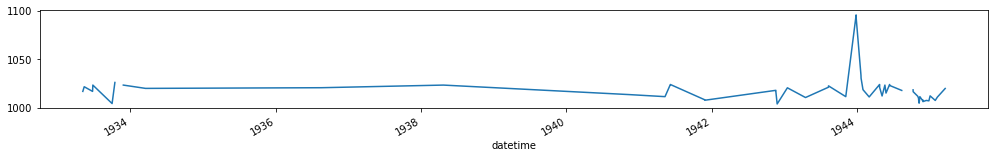

In [147]:
fig, ax = plt.subplots(figsize=(17, 2))
df_datetime.groupby('stationno').get_group('138').sort_index().pressure.plot(ax=ax)

In [148]:
df_datetime.sort_index().loc['1926-01']

,sourceno,id,octant,stationno,latitude,longitude,year,month,day,hour,pressure,drybulbF,rh,watertempF,datetime
datetime,,,,,,,,,,,,,,,
1926-01-01 08:00:00+00:00,(03,NaN,0.0,776,37.0,284.0,26,1,1,08,NaN,NaN,NaN,NaN,1926-01-01 08:00:00+00:00
1926-01-01 08:00:00+00:00,J04,NaN,0.0,144,41.0,316.0,26,01,1,08,1022.7,NaN,NaN,NaN,1926-01-01 08:00:00+00:00
1926-01-01 08:00:00+00:00,N13,NaN,1.0,317,33.0,243.0,26,1,1,8,1015.9,58.0,94.0,NaN,1926-01-01 08:00:00+00:00
1926-01-01 12:00:00+00:00,N13,NaN,1.0,317,33.0,243.0,26,1,1,12,1015.9,65.0,66.0,NaN,1926-01-01 12:00:00+00:00
1926-01-01 12:00:00+00:00,J04,NaN,0.0,144,41.0,316.0,26,01,1,12,1018.3,NaN,NaN,NaN,1926-01-01 12:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1926-01-31 12:00:00+00:00,N13,NaN,1.0,317,33.0,243.0,26,1,31,12,1008.8,60.0,89.0,NaN,1926-01-31 12:00:00+00:00
1926-01-31 12:00:00+00:00,(02,NaN,0.0,582,25.0,278.0,26,1,31,12,1013.9,75.0,78.0,72.0,1926-01-31 12:00:00+00:00
1926-01-31 16:00:00+00:00,J12,NaN,1.0,993,29.0,267.0,26,1,31,16,1013.9,NaN,NaN,NaN,1926-01-31 16:00:00+00:00


In [149]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [150]:
#define the basic map projection information and figure size

def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(20.5, 5.25),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

#download land mask
# 50m is a good balance between dataset size and land feature resolution
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')

/var/folders/vv/blq095kj0xj9nz1v0ffdwfch0000gp/T/ipykernel_3589/1965935684.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  t= df_datetime.loc['1942':'1943']
/Users/bell/miniconda3/envs/py38/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/bell/miniconda3/envs/py38/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


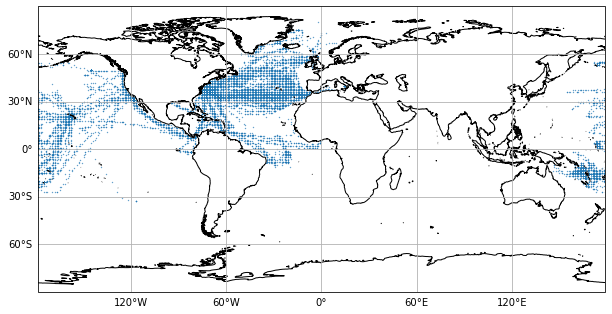

In [154]:
t= df_datetime.loc['1942':'1943']

fig,ax = make_map()
ax.scatter(t.longitude,t.latitude,.1)

ax.set_extent([-179,179,90,-90])
ax.add_feature(land_50m)
ax.coastlines(resolution='50m')


In [152]:
df_datetime.groupby('octant').count()

,sourceno,id,stationno,latitude,longitude,year,month,day,hour,pressure,drybulbF,rh,watertempF,datetime
octant,,,,,,,,,,,,,,
0.0,61236,8,61236,61236,61236,61236,61236,61236,61236,59087,60911,59146,47618,61236
1.0,91559,7,91559,91559,91559,91559,91559,91559,91559,89876,89954,89565,77556,91559
2.0,33518,1,33518,33518,33518,33518,33518,33518,33518,32446,33353,33170,30249,33518
3.0,833,0,833,833,833,833,833,833,833,826,829,801,766,833
5.0,1618,0,1618,1618,1618,1618,1618,1618,1618,1616,1616,1487,983,1618
6.0,885,0,885,885,885,885,885,885,885,885,868,860,461,885
7.0,3642,0,3642,3642,3642,3642,3642,3642,3642,3629,3612,3606,2512,3642
8.0,208,18,208,208,208,208,208,208,208,203,205,140,179,208
9.0,220,16,220,0,220,220,220,220,220,218,220,215,8,220
